# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data**

## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Check if CUDA is available (for GPU usage)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)

Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40

#print('torch version ', torch.__version__)


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [3]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    # Transform 'z-axis' column to float
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0, how='any', inplace=True)  # Drop NaN values

    return df

def convert_to_float(x):
    try:
        return np.float32(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

Then 'file_path' the directory to where you have put the data.

In [4]:
file_path = '../data/WISDM_ar_v1.1_raw.txt'
df = read_data(file_path)

In [5]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

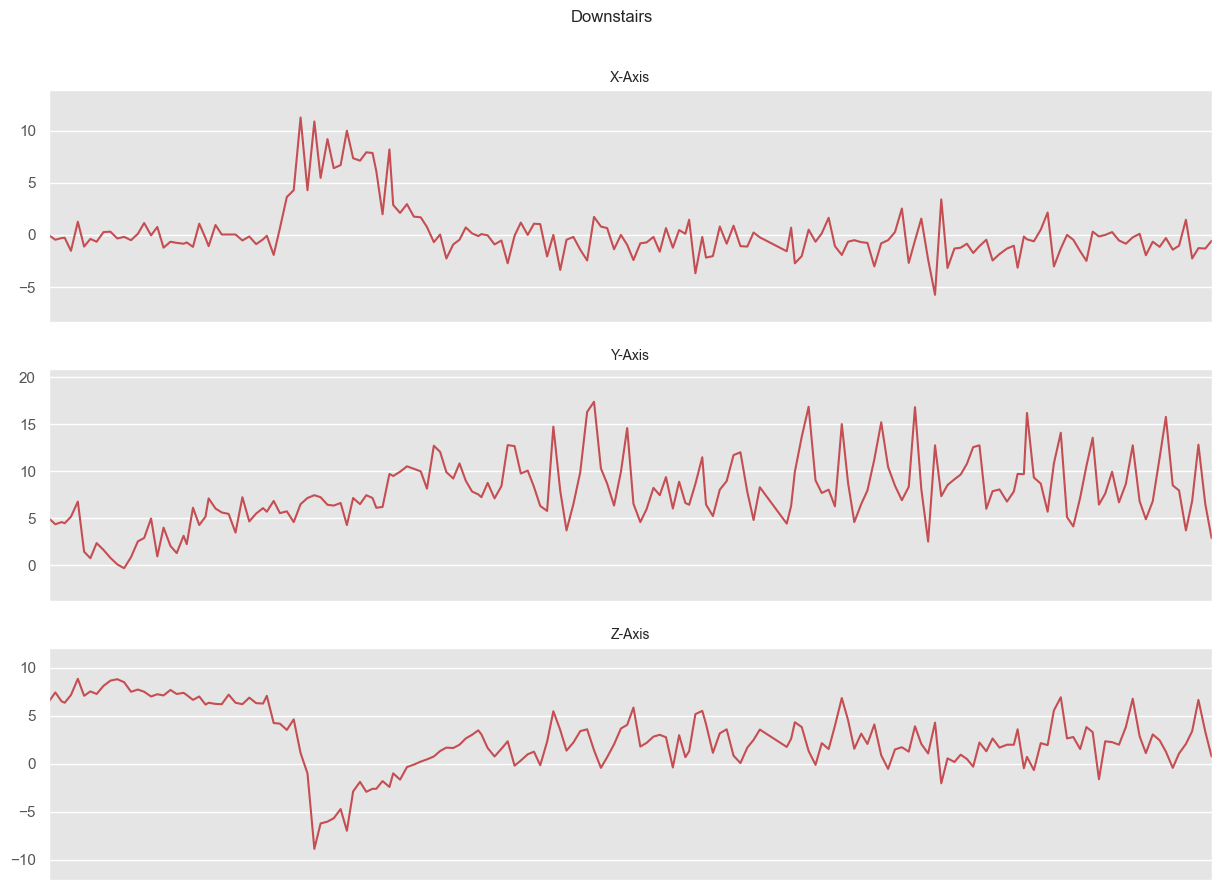

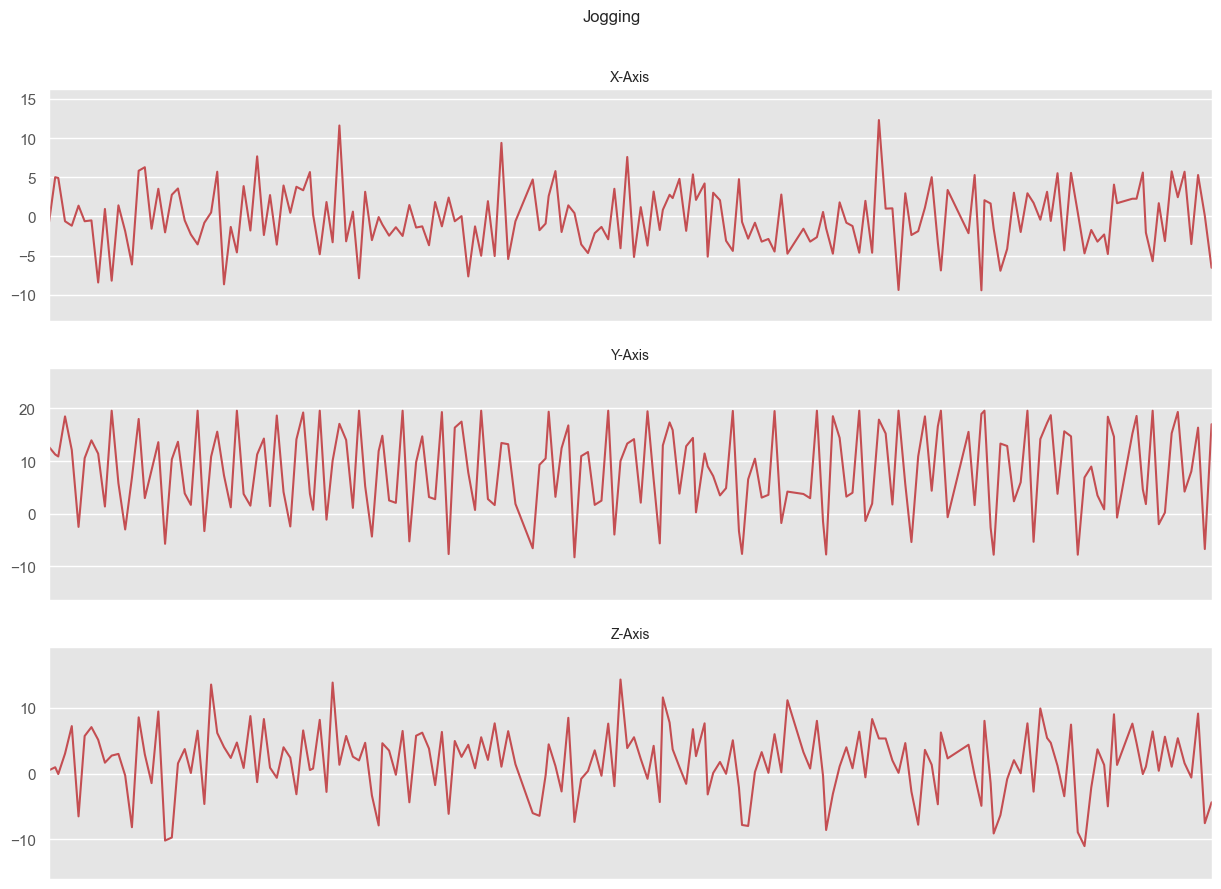

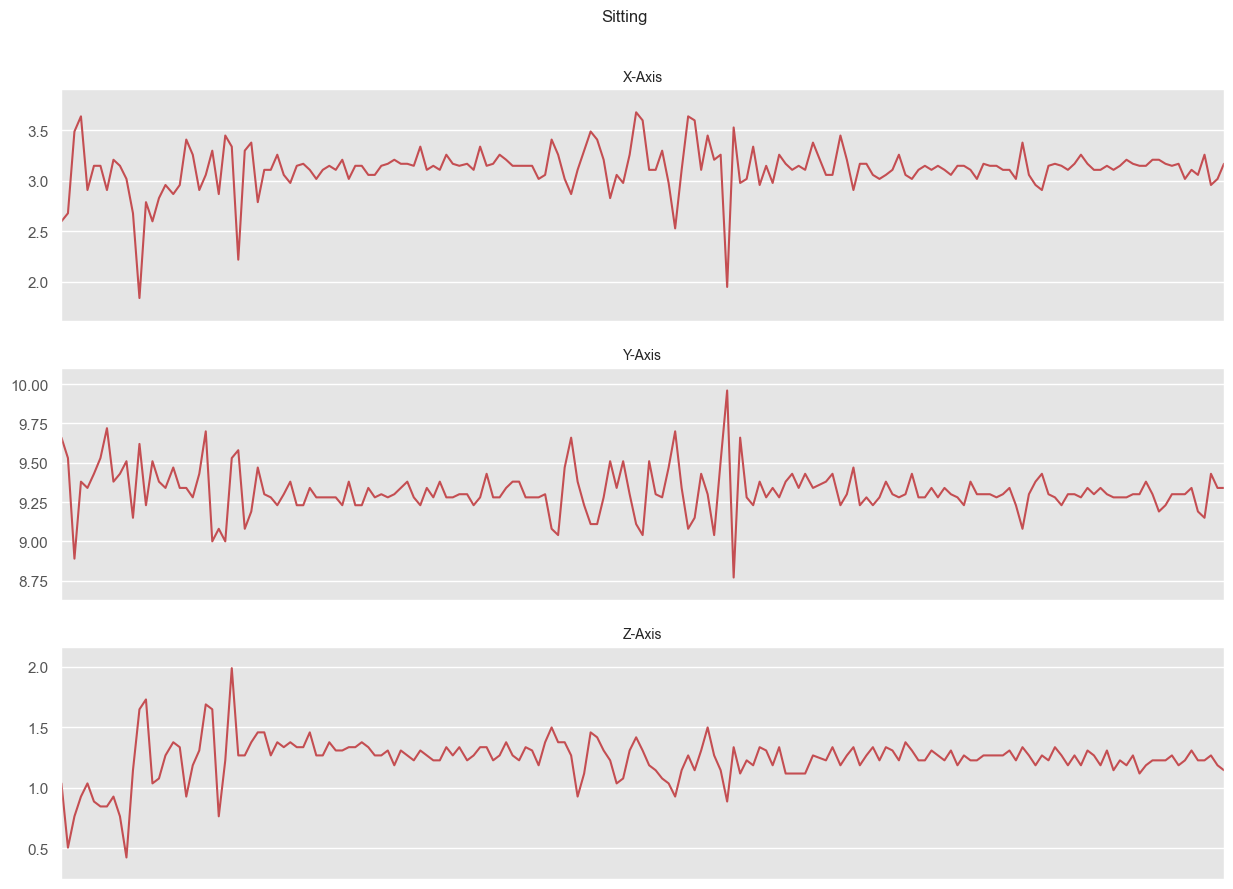

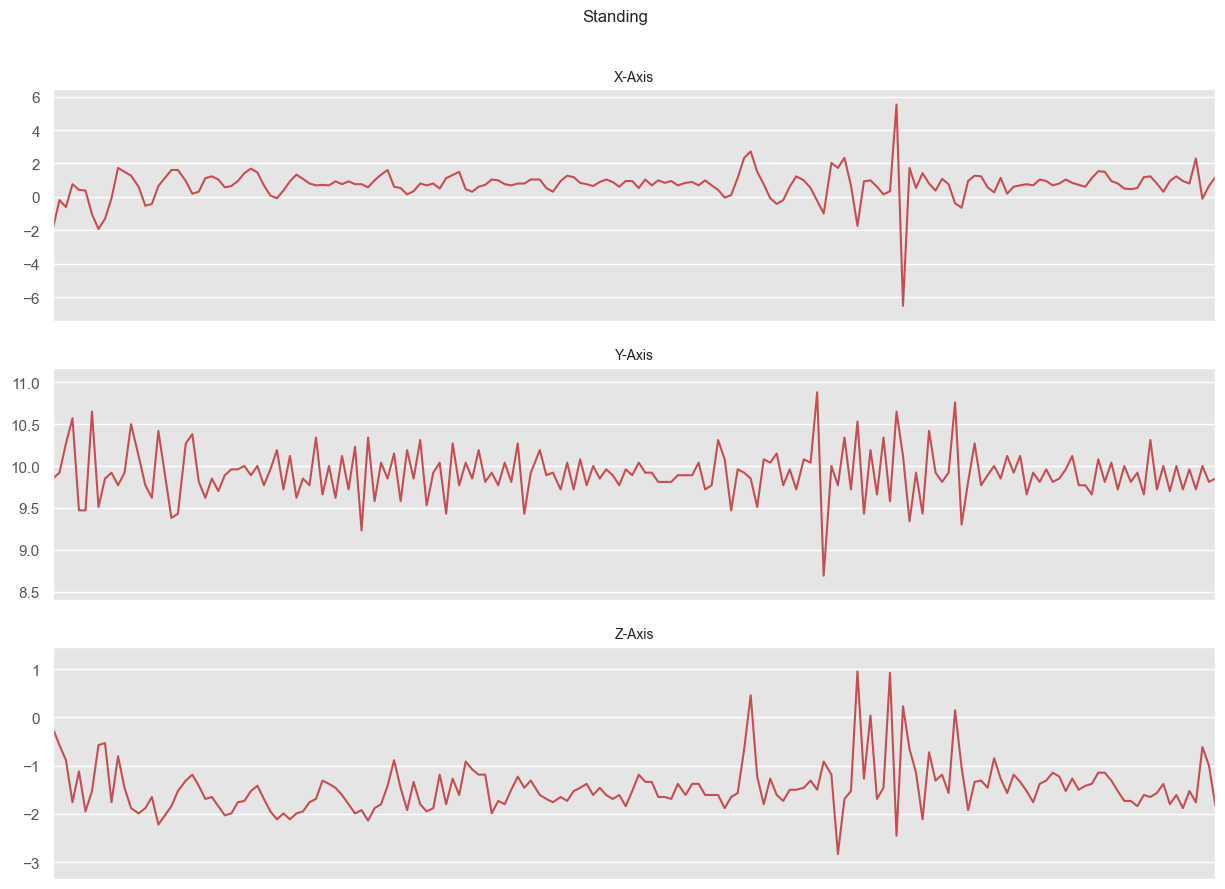

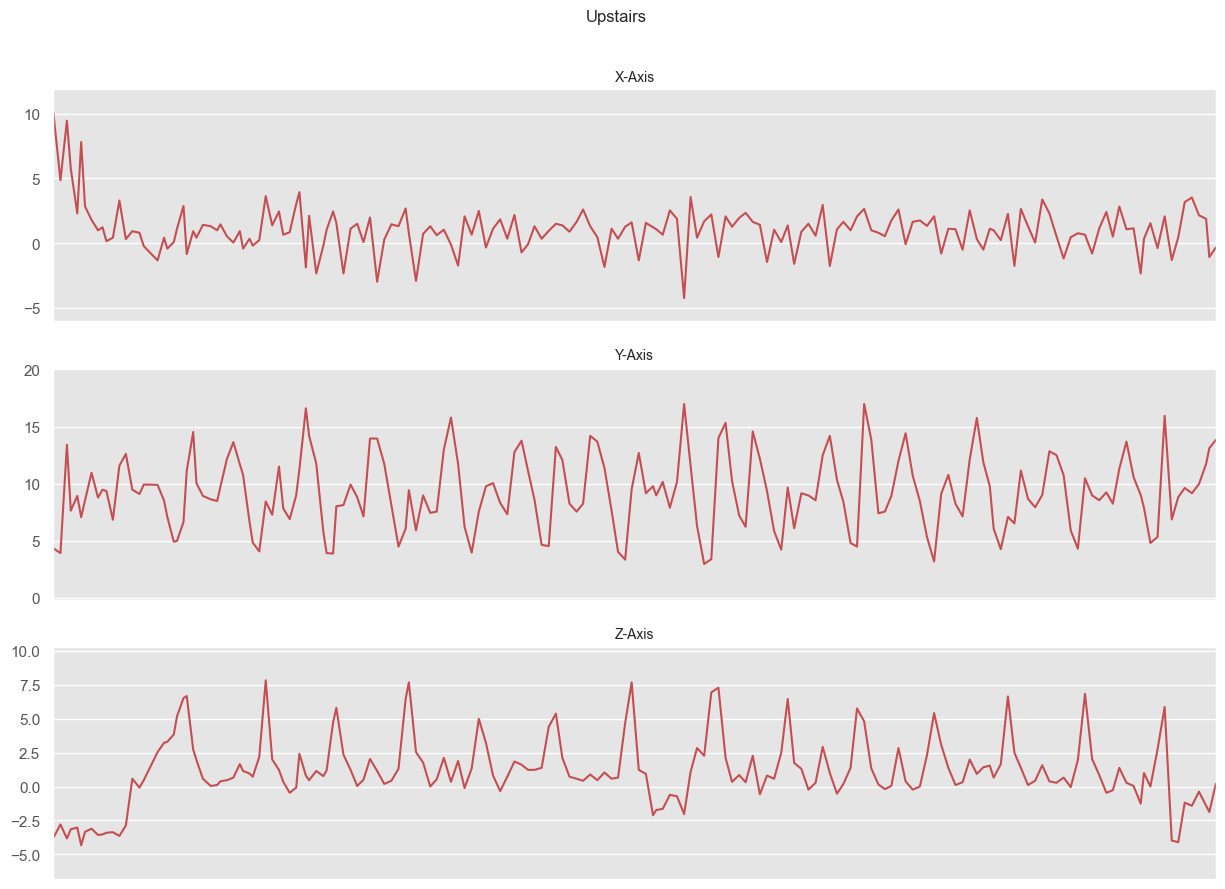

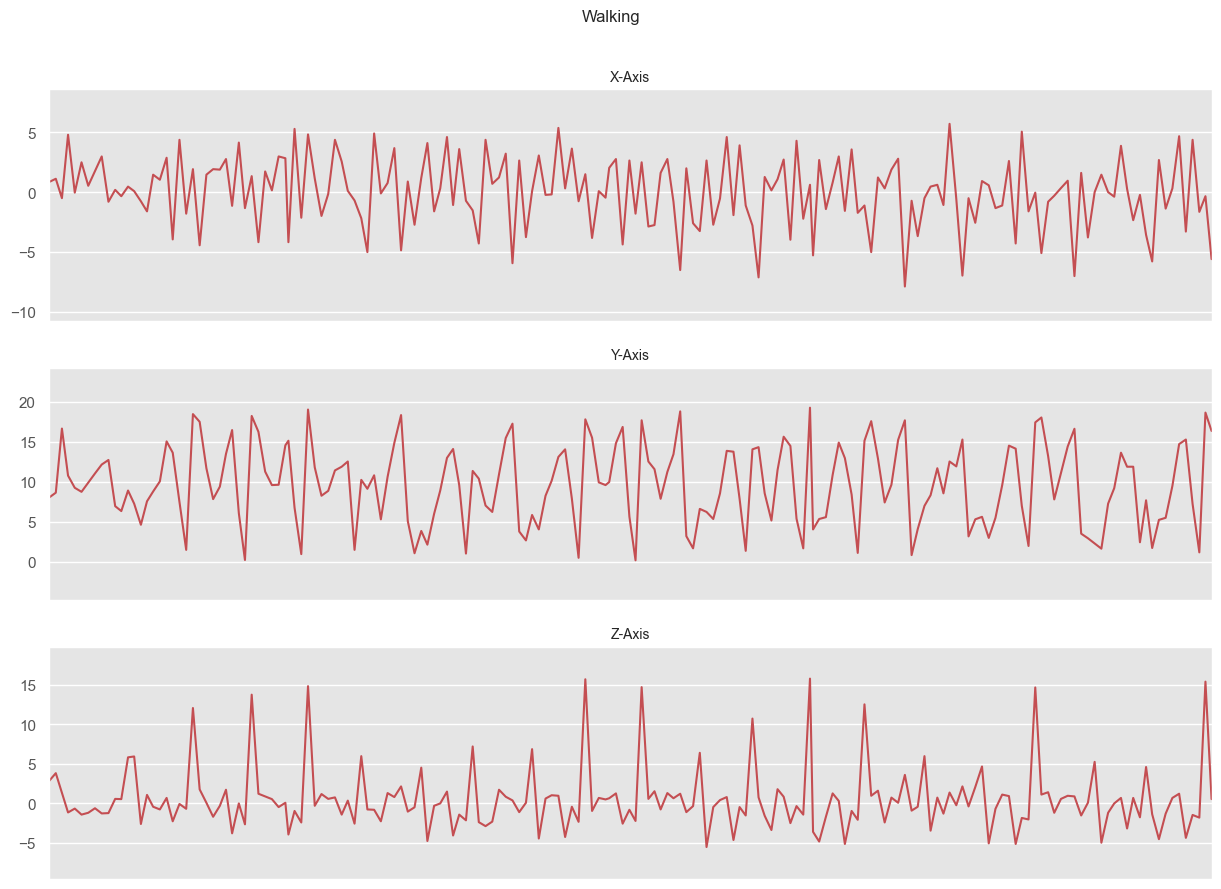

In [6]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')  # x
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')  # y
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [6]:
LABEL = 'ActivityEncoded' # from 0 to 5

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [7]:
# Split data into train and test set
# train: user 1 ~ 28
# test: user 28 ~

df_train = df[df['user'] <= 28]
df_test = df[df['user'] > 28]

In [8]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()


# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_train.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshape it.

In [9]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [10]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [11]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [12]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


In [13]:
# This function transforms integer y classes into one-hot-encoded vectors
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), accuracy_train: 0.9751407691386127, accuracy_val: 0.8979396262577863


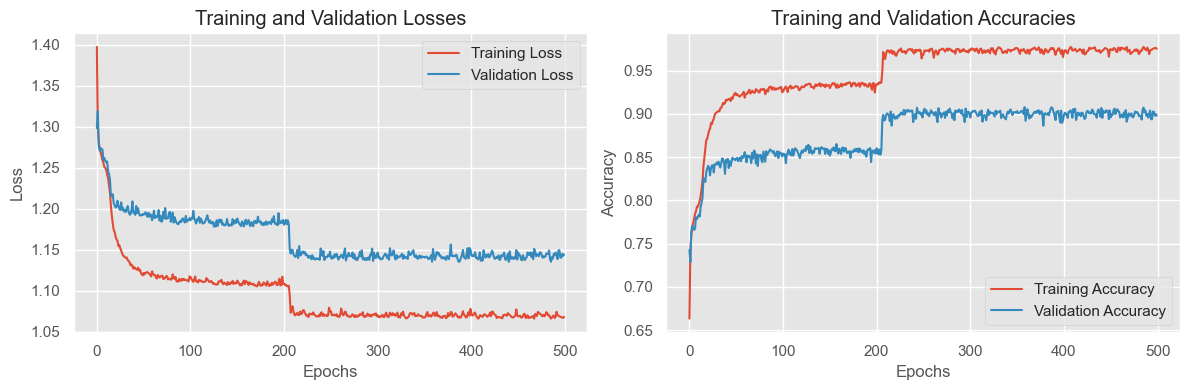

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), accuracy_train: 0.315981789864622, accuracy_val: 0.3097747963584092


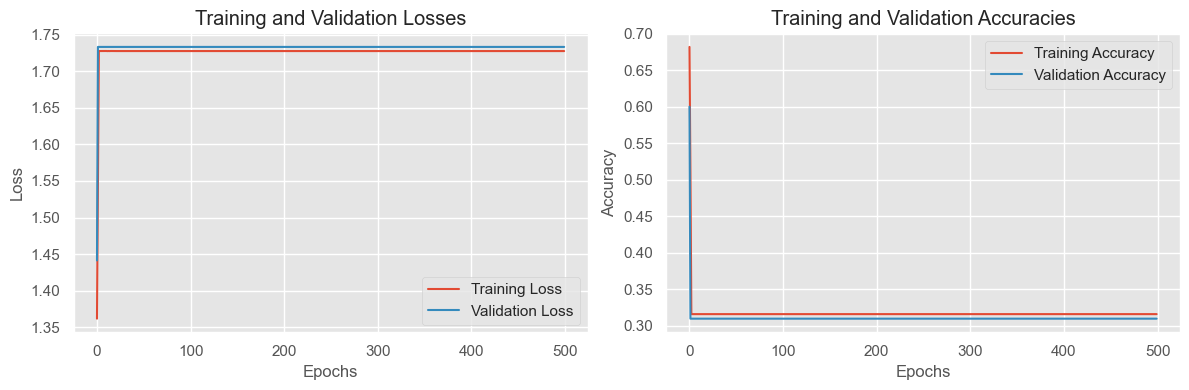

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
), accuracy_train: 0.315981789864622, accuracy_val: 0.3097747963584092


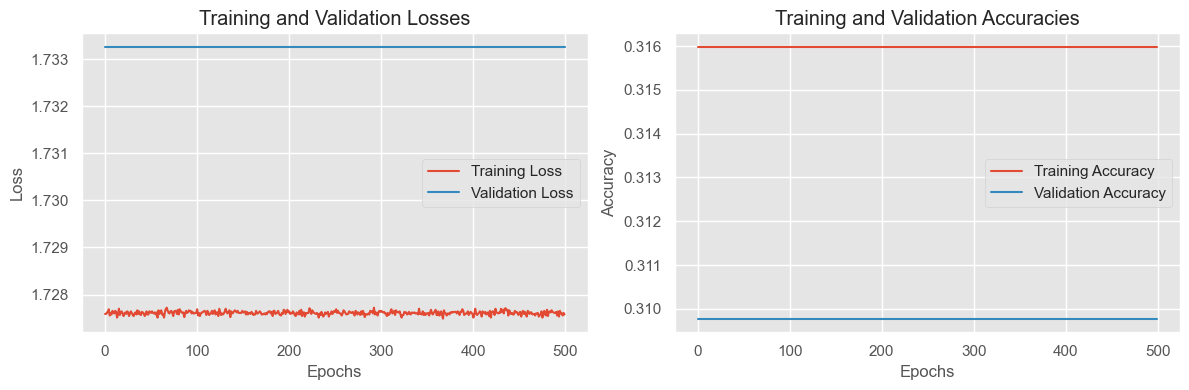

optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.9521983946328022, accuracy_val: 0.8919501677048395


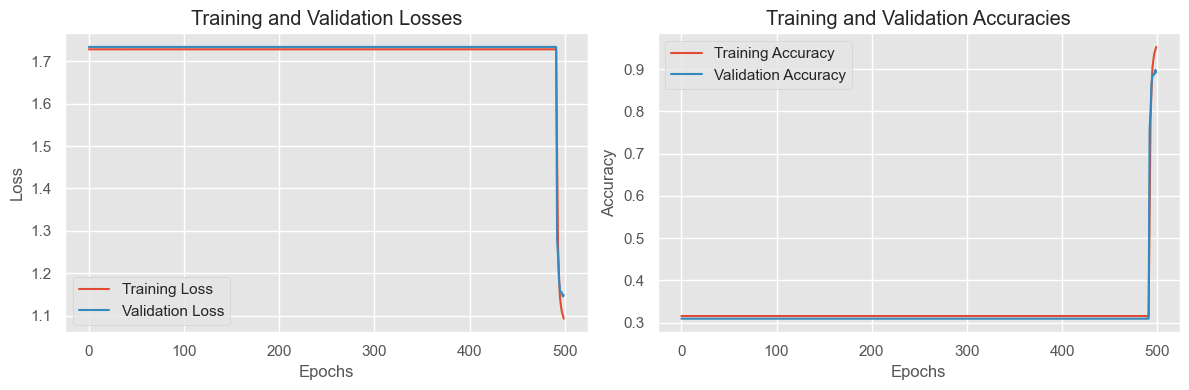

optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.7523661195639152, accuracy_val: 0.7434115955917585


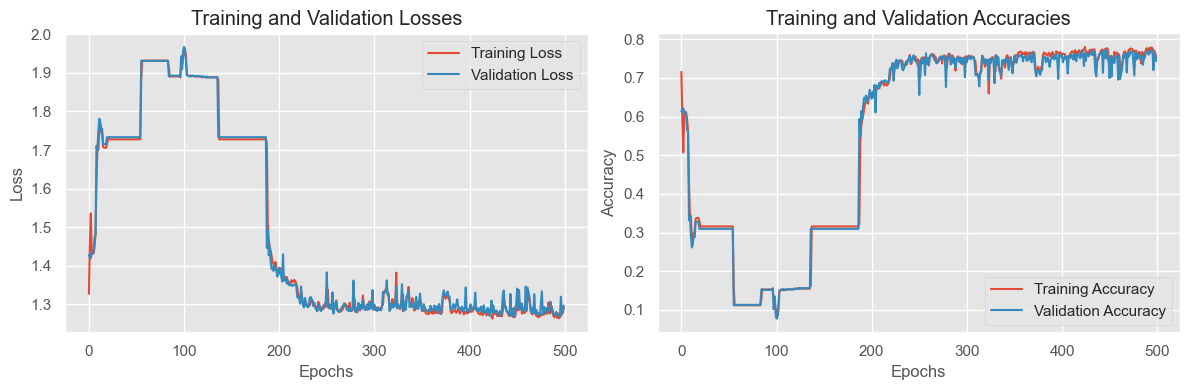

optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.39139810710434886, accuracy_val: 0.3988979396262578


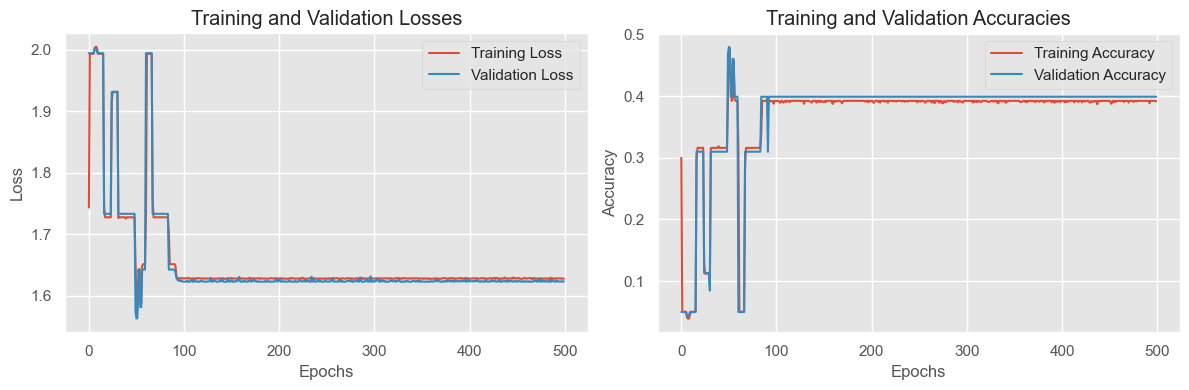

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.392176829998802, accuracy_val: 0.3988979396262578


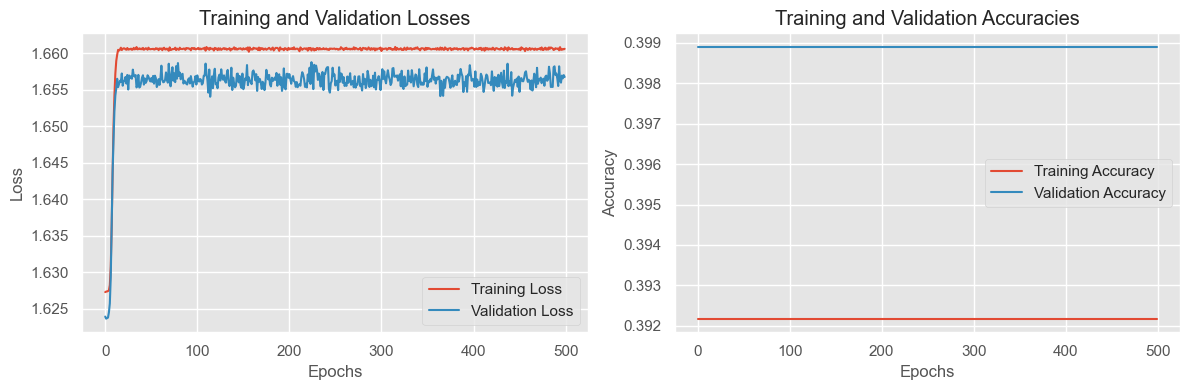

optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.392176829998802, accuracy_val: 0.3988979396262578


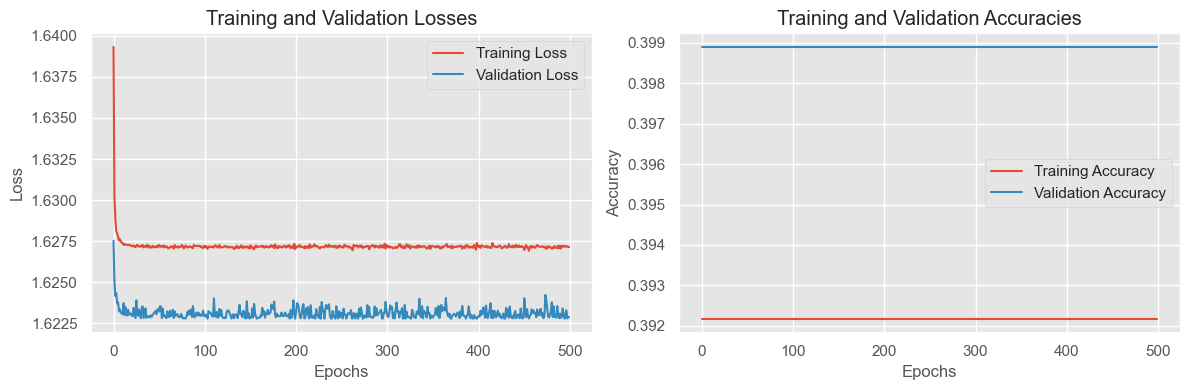

In [15]:
# MLP
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
results_df = []
paths = ['../images/optimizer/MLP/001.png', '../images/optimizer/MLP/01.png', '../images/optimizer/MLP/1.png',
         '../images/optimizer/MLP/001W.png', '../images/optimizer/MLP/01W.png', '../images/optimizer/MLP/1W.png',
         '../images/optimizer/MLP/01wd.png', '../images/optimizer/MLP/01Wwd.png']

# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs, path):
    # Plot losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.tight_layout() # prevent overlapping of subplots
    plt.savefig(path)
    plt.show()

np.random.seed(42)

class MyModel(nn.Module):
  def __init__(self, time_periods, n_classes):
    super(MyModel, self).__init__() # calls the constructor of the base class (nn.Module)
    self.time_periods = time_periods
    self.n_classes = n_classes

    # Flatten layer to reshape the input tensor
    self.flatten = nn.Flatten()

    # Fully connected layers with ReLU activation
    self.fc1 = nn.Linear(time_periods*3, 100)
    self.relu1 = nn.ReLU()

    self.fc2 = nn.Linear(100, 100)
    self.relu2 = nn.ReLU()

    self.fc3 = nn.Linear(100, 100)
    self.relu3 = nn.ReLU()

    # Final fully connected layer without activation for classification
    self.fc4 = nn.Linear(100, n_classes)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu1(self.fc1(x))
    x = self.relu2(self.fc2(x))
    x = self.relu3(self.fc3(x))
    x = self.fc4(x)
    x = F.softmax(x, dim=1)
    return x

  def predict(self, x):
    self.eval()

    # Convert numpy array to PyTorch tensor
    x_tensor = torch.tensor(x, dtype=torch.float32)

    # Perform forward pass to get predictions
    with torch.no_grad():
      x_tensor = x_tensor.to(device)
      probabilities = self.forward(x_tensor)

    return probabilities.cpu().numpy()

input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MyModel(TIME_PERIODS, n_classes)
model_mlp.to(device)
criterion = nn.CrossEntropyLoss()

my_optimizers = [torch.optim.Adam(model_mlp.parameters(), lr=0.001),
                 torch.optim.Adam(model_mlp.parameters(), lr=0.01),
                 torch.optim.Adam(model_mlp.parameters(), lr=0.1),
                 torch.optim.AdamW(model_mlp.parameters(), lr=0.001),
                 torch.optim.AdamW(model_mlp.parameters(), lr=0.01),
                 torch.optim.AdamW(model_mlp.parameters(), lr=0.1),
                 torch.optim.Adam(model_mlp.parameters(), lr=0.01, weight_decay=0.01),
                 torch.optim.AdamW(model_mlp.parameters(), lr=0.01, weight_decay=0.01)]

# Define 3 DataLoader : train, validation and test

np.random.seed(42)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define validation dataset
total_train_size = len(train_dataset)
train_size = int(0.8 * total_train_size)
val_size = total_train_size - train_size

# Redefine train and validation TensorDatasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64  # You can change this value as per your need : number of samples that will be processed in each iteration during training or testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to train the model
def train(model, device, num_epochs, optimizer):
    # Initialize lists to store train/validation losses and accuracies
    global train_losses, val_losses, train_accs, val_accs
    
    for epoch in range(num_epochs): # Iteration over train epochs
        model.train()
        running_train_loss = 0 # Loss associated with epoch
        total_train = 0 # Number of train instances for this epoch
        correct_train = 0 # Number of train instances that are correctly classified by the model

        for inputs, labels in train_loader: # Iteration over train examples (mini-batchs)
            # This ensures that all operations involving the inputs and labels are performed on the same device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # we put to zero the gradients of the previous batch
            outputs = model(inputs) # we compute the forward pass of the model : outputs are predictions for the given inputs
            loss = criterion(outputs, labels) # calculate the loss between outputs and labels with the specified criterion
            loss.backward() # backpropagation : computing the gradients of the model parameters with respect to the loss
            optimizer.step() # we update the model parameters using the gradients computed in the backward pass

            running_train_loss += loss.item() # accumulation of loss for each batch

            _, predicted = outputs.max(1) # predicted class for each input in the batch
            total_train += labels.size(0) # increments the total_train variable by the number of samples in the current batch
            correct_train += predicted.eq(labels).sum().item() # calculates the number of correct predictions in the current batch

        # dividing the accumulated running loss by the total number of batches in the training dataset
        average_train_loss = running_train_loss/len(train_loader)
        # dividing the total number of correctly predicted samples by the total number of samples in the training dataset
        train_accuracy = correct_train/total_train

        # Append the metrics to the lists
        train_losses.append(average_train_loss)
        train_accs.append(train_accuracy)

        # Validation dataset
        model.eval()
        running_val_loss = 0
        correct_val = 0
        total_val = 0

        # During inference or validation, where we are not updating the model's parameters based on gradients,
        # it is a good practice to disable gradient computation using torch.no_grad() to optimize memory usage and computational efficiency.
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()

                _, predicted_val = val_outputs.max(1)
                total_val += val_labels.size(0)
                correct_val += predicted_val.eq(val_labels).sum().item()

        average_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Append the metrics to the lists
        val_losses.append(average_val_loss)
        val_accs.append(val_accuracy)
    return(train_losses, val_losses, train_accs, val_accs)

results_df = []

for i in range(len(my_optimizers)):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  my_optimizer = my_optimizers[i]

  # Choose your Optimizer
  train_losses, val_losses, train_accs, val_accs = train(model_mlp, device, 500, my_optimizer)

  # Check if this set of hyperparameters gives better accuracy
  print(f"optimizer: {my_optimizer}, accuracy_train: {train_accs[-1]}, accuracy_val: {val_accs[-1]}")

  # normalize test data
  df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
  df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
  df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
  df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
  _x_test, _y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

  _x_test = _x_test.reshape(x_test.shape[0], input_shape)

  _x_test = _x_test.astype('float32')
  _y_test = _y_test.astype('float32')

  _y_test = to_categorical(_y_test, n_classes)
  y_pred_test = model_mlp.predict(_x_test)
  max_y_pred_test = np.argmax(y_pred_test, axis=1)
  max_y_test = np.argmax(_y_test, axis=1)

  results_df.append([my_optimizer, train_accs[-1], val_accs[-1], accuracy_score(max_y_test, max_y_pred_test)])
  plot_performance(train_losses, val_losses, train_accs, val_accs, paths[i])  
  

In [16]:
results_df

[[Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.001
      maximize: False
      weight_decay: 0
  ),
  0.9751407691386127,
  0.8979396262577863,
  0.7703523693803159],
 [Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.01
      maximize: False
      weight_decay: 0
  ),
  0.315981789864622,
  0.3097747963584092,
  0.3019441069258809],
 [Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.1
      maximize: False
      weight_decay: 0
  ),
  0.315981789864622,
  0.3097747963584092,
  0.3019441069258809],
 [AdamW (
  Parameter Group 0
      amsgrad: False
      bet

Early stopping triggered after 144 epochs without improvement.
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), accuracy_train: 0.9884988618665389, accuracy_val: 0.9734068040249162


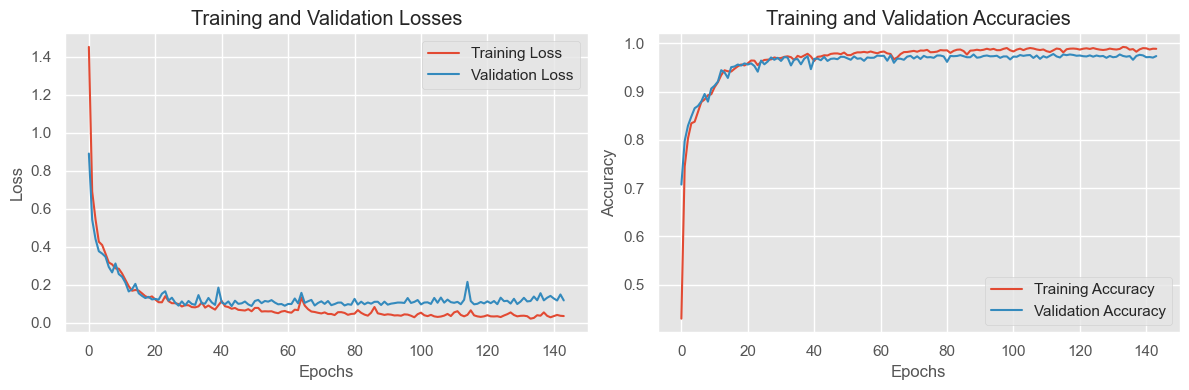

Early stopping triggered after 101 epochs without improvement.
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
), accuracy_train: 0.3884629208098718, accuracy_val: 0.39051269765213226


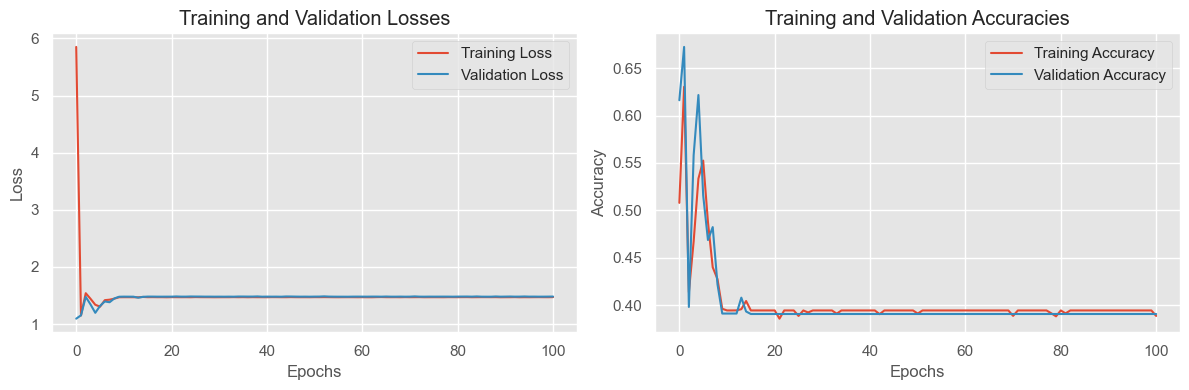

optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.39427339163771413, accuracy_val: 0.39051269765213226


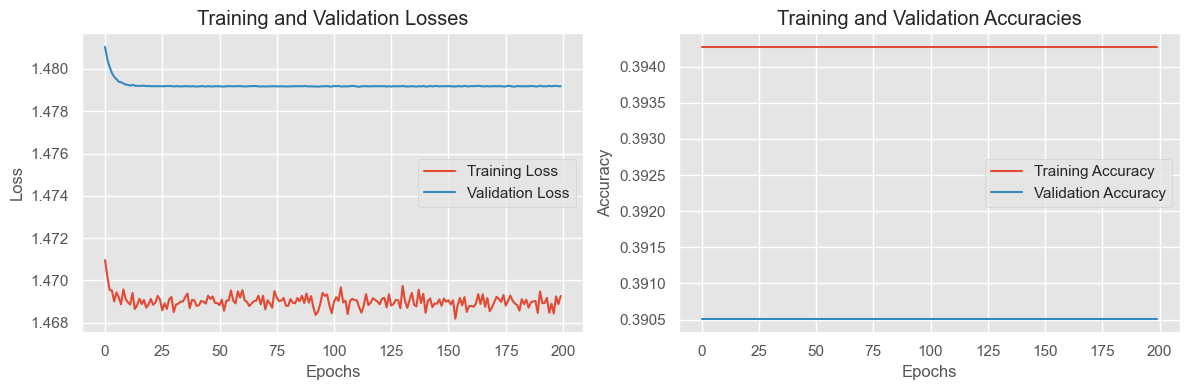

Early stopping triggered after 131 epochs without improvement.
optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.39427339163771413, accuracy_val: 0.39051269765213226


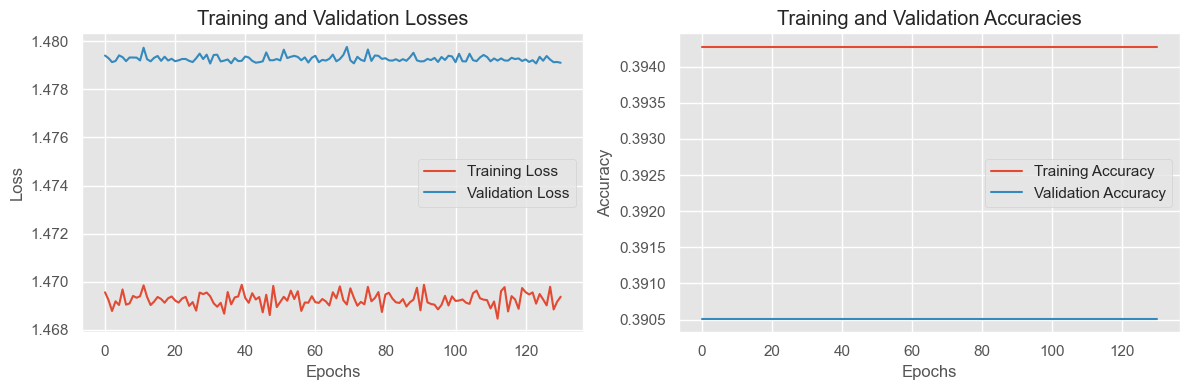

Early stopping triggered after 186 epochs without improvement.
optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.39427339163771413, accuracy_val: 0.39051269765213226


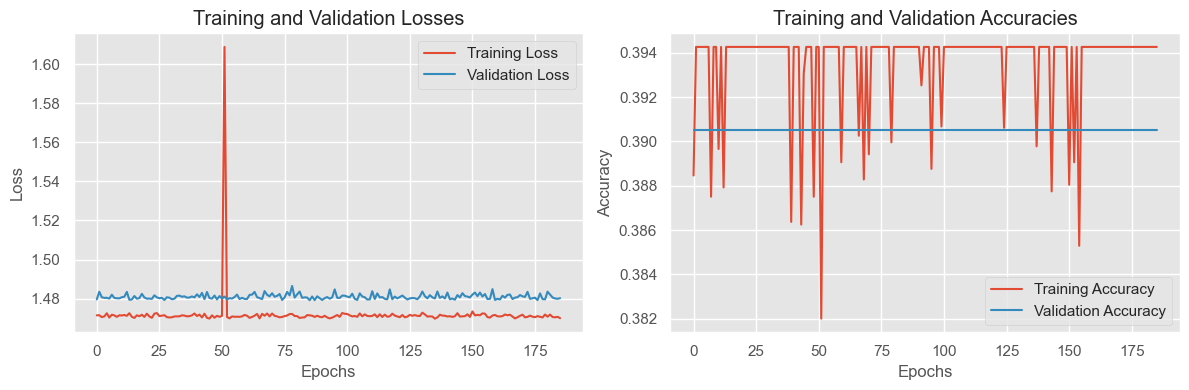

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
), accuracy_train: 0.8636635917095963, accuracy_val: 0.8893148059415429


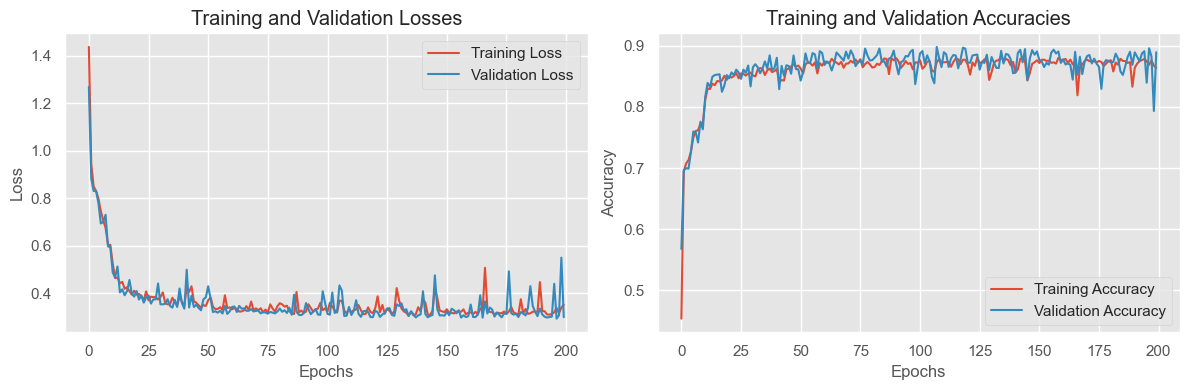

In [14]:
# MLP
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
results_df = []
paths = ['../images/optimizer/CNN/01.png', '../images/optimizer/CNN/1.png',
         '../images/optimizer/CNN/001W.png', '../images/optimizer/CNN/01W.png', '../images/optimizer/CNN/1W.png',
         '../images/optimizer/CNN/01wd.png']

# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs, path):
    # Plot losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.tight_layout() # prevent overlapping of subplots
    plt.savefig(path)
    plt.show()

np.random.seed(42)

class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes, 
                 nb_conv_layers = 5, activation_function = nn.ReLU(), 
                 pooling = "avg", kernel_size = 5, stride = 1):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes
        self.nb_conv_layers = nb_conv_layers
        self.activation_function = activation_function
        self.pooling = pooling
        self.kernel_size = kernel_size
        self.stride = stride

        # Input size for the first linear layer
        input_size = self.n_sensors

        # Create hidden layers with ReLU activation
        self.conv_layers = nn.ModuleList() # creates a list of layers
        for layer in range(nb_conv_layers):
            if layer <= 1:
                self.conv_layers.append(nn.Conv1d(input_size, 100,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride,
                                                  padding = 5))
                self.conv_layers.append(activation_function)
                input_size = 100 # Update input size for the next layer
            else :
                self.conv_layers.append(nn.Conv1d(input_size, 160,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride,
                                                  padding = 5))
                self.conv_layers.append(activation_function)
                input_size = 160 # Update input size for the next layer

        # Pooling and dropout
        if pooling == "max":
            self.pool = nn.MaxPool1d(kernel_size=3)
        else :
            self.pool = nn.AvgPool1d(kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

        #raise NotImplementedError

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x_batch_size = x.size(0)
        x = x.reshape(x_batch_size, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            # Pooling every 2 layers
            if i % 4 == 0 and i != 0 and i < len(self.conv_layers)-1:
                x = self.pool(x)

        # Global average pooling and dropout
        x = self.avgpool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.reshape(x_batch_size, -1)

        # Output layer with softmax activation
        x = self.fc(x)

        # output the loss, Use log_softmax for numerical stability
        x = F.log_softmax(x, dim=1)
        return x
    
    def predict(self, x):
        self.eval()

        # Convert numpy array to PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Perform forward pass to get predictions
        with torch.no_grad():
          x_tensor = x_tensor.to(device)
          probabilities = self.forward(x_tensor)

        return probabilities.cpu().numpy()

input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Assuming TIME_PERIODS and n_classes are defined
model_cnn = MyConvModel(TIME_PERIODS, n_sensors, n_classes)
model_cnn.to(device)
criterion = nn.CrossEntropyLoss()

my_optimizers = [torch.optim.Adam(model_cnn.parameters(), lr=0.01),
                 torch.optim.Adam(model_cnn.parameters(), lr=0.1),
                 torch.optim.AdamW(model_cnn.parameters(), lr=0.001),
                 torch.optim.AdamW(model_cnn.parameters(), lr=0.01),
                 torch.optim.AdamW(model_cnn.parameters(), lr=0.1),
                 torch.optim.Adam(model_cnn.parameters(), lr=0.01, weight_decay=0.01)]

# Define 3 DataLoader : train, validation and test
np.random.seed(42)
from torch.utils.data import random_split

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define validation dataset
total_train_size = len(train_dataset)
train_size = int(0.8 * total_train_size)
val_size = total_train_size - train_size

# Redefine train and validation TensorDatasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 400  # You can change this value as per your need : number of samples that will be processed in each iteration during training or testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to train the model
def train(model, device, num_epochs, optimizer):
    # Initialize lists to store train/validation losses and accuracies
    global train_losses, val_losses, train_accs, val_accs, best_val_loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            my_optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            my_optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = correct_train/total_train
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = correct_val/total_val
        val_loss = running_loss/len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
                break

    return(train_losses, val_losses, train_accs, val_accs)

results_df = []

for i in range(len(my_optimizers)):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  my_optimizer = my_optimizers[i]

  best_val_loss = float('inf')
  patience = 100
  trigger_times = 0

  # Choose your Optimizer
  train_losses, val_losses, train_accs, val_accs = train(model_cnn, device, 200, my_optimizer)

  # Check if this set of hyperparameters gives better accuracy
  print(f"optimizer: {my_optimizer}, accuracy_train: {train_accs[-1]}, accuracy_val: {val_accs[-1]}")

  # normalize test data
  df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
  df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
  df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
  df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
  _x_test, _y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

  _x_test = _x_test.reshape(x_test.shape[0], input_shape)

  _x_test = _x_test.astype('float32')
  _y_test = _y_test.astype('float32')

  _y_test = to_categorical(_y_test, n_classes)
  y_pred_test = model_cnn.predict(_x_test)
  max_y_pred_test = np.argmax(y_pred_test, axis=1)
  max_y_test = np.argmax(_y_test, axis=1)

  results_df.append([my_optimizer, train_accs[-1], val_accs[-1], accuracy_score(max_y_test, max_y_pred_test)])
  plot_performance(train_losses, val_losses, train_accs, val_accs, paths[i])  
  

In [15]:
results_df

[[Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.01
      maximize: False
      weight_decay: 0
  ),
  0.9884988618665389,
  0.9734068040249162,
  0.8367253948967193],
 [Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.1
      maximize: False
      weight_decay: 0
  ),
  0.3884629208098718,
  0.39051269765213226,
  0.3643681652490887],
 [AdamW (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.001
      maximize: False
      weight_decay: 0.01
  ),
  0.39427339163771413,
  0.39051269765213226,
  0.3643681652490887],
 [AdamW (
  Parameter Group 0
      amsgrad: False
